This notebook demonstrates how samples from a flow can be degraded to simulate different systematics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from utils import InvRedshiftIncompleteness, LineConfusion, photoz_stats

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

First, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

Let's create a samples from a creator with and without this selection function, and compare their redshift distributions.

In [3]:
flow = Flow(file="saved-flows/desc-dc2-redshift-flow.pkl")

In [4]:
complete_sample = flow.sample(1000000, seed=0)
incomplete_sample = InvRedshiftIncompleteness(0.8)(flow.sample(1500000, seed=0))[:1000000]

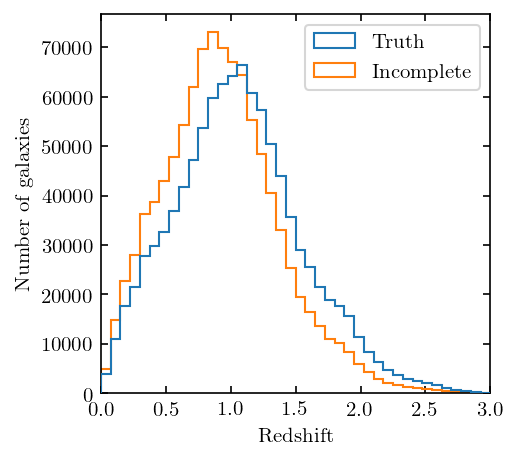

In [5]:
fig, ax = plt.subplots()
ax.hist(complete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Truth", zorder=10)
ax.hist(incomplete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Incomplete")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0, 3))
plt.show()

We can see that the biased samples have more low redshift galaxies, and a deficit of galaxies with redshift > 0.8.

Now let's train a flow as a photo-z estimator on the degraded sample.

In [6]:
# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = incomplete_sample.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [incomplete_sample.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([incomplete_sample['redshift'], 
                      incomplete_sample['r'], 
                      incomplete_sample['u'] - incomplete_sample['g'], 
                      incomplete_sample['g'] - incomplete_sample['r'], 
                      incomplete_sample['r'] - incomplete_sample['i'], 
                      incomplete_sample['i'] - incomplete_sample['z'], 
                      incomplete_sample['z'] - incomplete_sample['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = incomplete_sample.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2, transformed_dim=1, B=5),
)

In [7]:
%%time
incomplete_flow = Flow(incomplete_sample.columns, bijector)
incomplete_losses = incomplete_flow.train(incomplete_sample[:800000], epochs=200, verbose=True)

Training 200 epochs 
Loss:
10.1136
-5.4725
-7.8449
-8.0882
-8.3386
-8.5645
-8.5513
-8.6432
-8.7447
-8.5833
-8.7745
-8.5174
-8.8532
-8.7358
-8.8630
-8.6813
-8.8622
-8.8508
-8.8897
-8.8410
-8.8813
CPU times: user 12h 27min 2s, sys: 3h 20min 35s, total: 15h 47min 38s
Wall time: 2h 14min 52s


Print the test loss

In [23]:
-np.mean(incomplete_flow.log_prob(incomplete_sample[800000:]))

DeviceArray(-8.701633, dtype=float32)

Save this flow

In [9]:
incomplete_flow.info = f"""
Flow for the forward model section of the pzflow paper.
Trained on an incomplete set of a million galaxies from DESC DC2.

This flow was created with pzflow version {pzflow.__version__}
"""
incomplete_flow.save("saved-flows/incomplete-redshift-flow.pkl")

Now, let's demonstrate `LineConfusion`. This is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

Let's use the `LineConfusion` degrader to create an `OxygenLineConfusion` degrader, in which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines.

Again, we will make samples with and without this degradation, this time comparing the spec-z's

In [18]:
def OxygenLineConfusion(data, seed=None):
    OII = 3727
    OIII = 5007
    
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)
    return data

In [11]:
specz_err_sample = OxygenLineConfusion(complete_sample, seed=0)

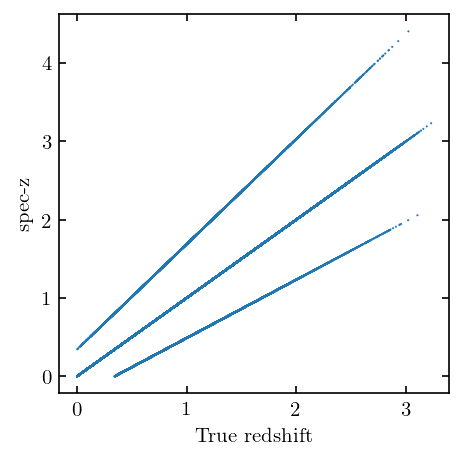

In [12]:
fig, ax = plt.subplots()
ax.scatter(complete_sample["redshift"], specz_err_sample["redshift"], s=1, edgecolor="None")
ax.set(xlabel="True redshift", ylabel="spec-z")
plt.show()

The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.

Now let's train a flow as a photo-z estimator on the sample with spec-z errors.

In [13]:
%%time
specz_err_flow = Flow(specz_err_sample.columns, bijector)
specz_err_losses = specz_err_flow.train(specz_err_sample[:800000], epochs=200, verbose=True)

Training 200 epochs 
Loss:
11.4408
-4.9678
-7.2454
-7.0962
-7.8513
-8.0066
-7.9592
-7.9376
-8.3324
-8.1309
-8.2776
-8.1644
-8.3869
-8.3657
-8.1766
-8.4110
-8.4969
-8.4725
-8.4234
-8.4279
-8.4505
CPU times: user 10h 58min 44s, sys: 3h 11min 48s, total: 14h 10min 33s
Wall time: 1h 54min 36s


Print the test error

In [22]:
-np.mean(specz_err_flow.log_prob(specz_err_sample[800000:]))

DeviceArray(-8.418908, dtype=float32)

Save this flow

In [15]:
specz_err_flow.info = f"""
Flow for the forward model section of the pzflow paper.
Trained on a set of a million galaxies with spec-z errors from DESC DC2.

This flow was created with pzflow version {pzflow.__version__}
"""
specz_err_flow.save("saved-flows/specz-err-redshift-flow.pkl")

Now let's train one more flow on the complete sample, to serve as a benchmark for photo-z estimation.

In [16]:
# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = complete_sample.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [complete_sample.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([complete_sample['redshift'], 
                      complete_sample['r'], 
                      complete_sample['u'] - complete_sample['g'], 
                      complete_sample['g'] - complete_sample['r'], 
                      complete_sample['r'] - complete_sample['i'], 
                      complete_sample['i'] - complete_sample['z'], 
                      complete_sample['z'] - complete_sample['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = complete_sample.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2, transformed_dim=1, B=5),
)

In [17]:
%%time
complete_flow = Flow(complete_sample.columns, bijector)
complete_losses = complete_flow.train(complete_sample[:800000], epochs=200, verbose=True)

Training 200 epochs 
Loss:
10.5165
-5.2956
-7.7252
-8.0950
-8.1692
-8.4141
-8.4936
-8.5177
-8.4794
-8.4224
-8.5571
-8.7271
-8.7272
-8.8350
-8.6494
-8.8128
-8.6587
-8.7928
-8.8228
-8.7026
-8.8698
CPU times: user 10h 51min 20s, sys: 3h 27min 57s, total: 14h 19min 17s
Wall time: 1h 55min 6s


Print test loss

In [24]:
-np.mean(complete_flow.log_prob(complete_sample[800000:]))

DeviceArray(-8.915075, dtype=float32)

Save this flow

In [25]:
complete_flow.save("saved-flows/complete-redshift-flow.pkl")

Load all the flows trained above.

In [3]:
flow = Flow(file="saved-flows/desc-dc2-dr6-redshift-flow.pkl")
complete_flow = Flow(file="saved-flows/complete-redshift-flow.pkl")
incomplete_flow = Flow(file="saved-flows/incomplete-redshift-flow.pkl")
specz_err_flow = Flow(file="saved-flows/specz-err-redshift-flow.pkl")

In [5]:
test_complete_sample = flow.sample(20000, seed=1)

Let's calculate a bunch of posteriors and print some stats

In [6]:
grid = np.arange(0, 3.02, 0.02)
true_pdfs = flow.posterior(test_complete_sample, column="redshift", grid=grid, batch_size=10000)
complete_pdfs = complete_flow.posterior(test_complete_sample, column="redshift", grid=grid, batch_size=10000)
incomplete_pdfs = incomplete_flow.posterior(test_complete_sample, column="redshift", grid=grid, batch_size=10000)
specz_err_pdfs = specz_err_flow.posterior(test_complete_sample, column="redshift", grid=grid, batch_size=10000)

In [7]:
def zmode(pdfs):
    return grid[np.argmax(pdfs, axis=1)]

In [8]:
for name, pdfs in zip(["true", "complete", "incomplete", "specz_err"],
                      [true_pdfs, complete_pdfs, incomplete_pdfs, specz_err_pdfs]):
    print(f"Median KLDiv of {name}: {np.median(entropy(pdfs, qk=true_pdfs, axis=1))}")

Median KLDiv of true: 0.0
Median KLDiv of complete: 2.274156332015991
Median KLDiv of incomplete: 2.684408664703369
Median KLDiv of specz_err: 5.6988091468811035


In [10]:
for name, pdfs in zip(["true", "complete", "incomplete", "specz_err"],
                      [true_pdfs, complete_pdfs, incomplete_pdfs, specz_err_pdfs]):
    bias, sig, fout = photoz_stats(zmode(pdfs), test_complete_sample["redshift"].values)
    print(f"{name}: bias - {bias:.5f}, std - {sig:.3f}, fout - {fout:.3f}")

true: bias - -0.00002, std - 0.004, fout - 0.026
complete: bias - 0.00162, std - 0.011, fout - 0.148
incomplete: bias - -0.00045, std - 0.012, fout - 0.149
specz_err: bias - 0.00193, std - 0.013, fout - 0.267


Let's also make a plot showing these two biases

In [19]:
incomplete_sample = InvRedshiftIncompleteness(0.8)(flow.sample(150000, seed=0))[:100000]
specz_err_sample = OxygenLineConfusion(complete_sample, seed=0)

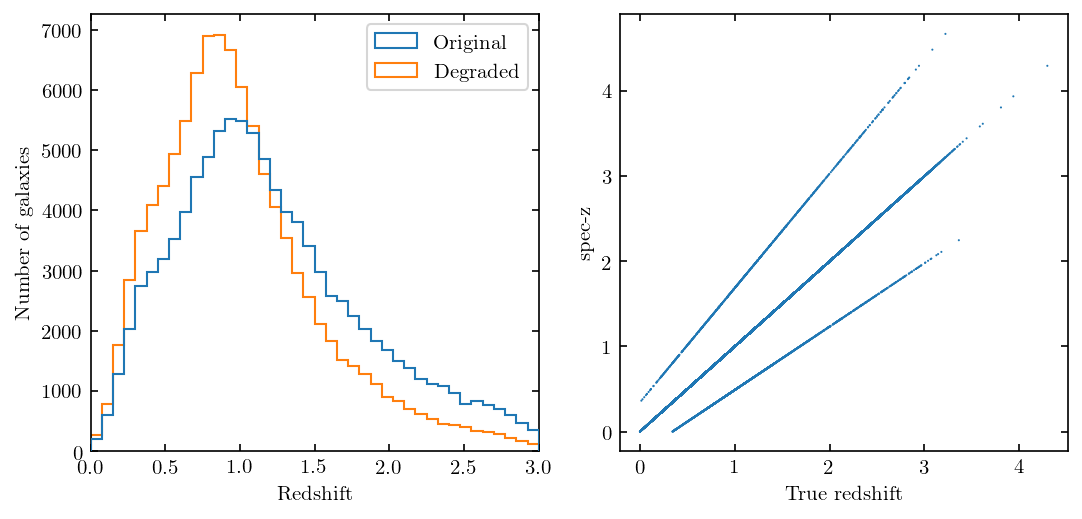

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(twocol, onecol), constrained_layout=True)

ax1.hist(complete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Original", zorder=10)
ax1.hist(incomplete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Degraded")
ax1.legend()
ax1.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0, 3))

ax2.scatter(complete_sample["redshift"], specz_err_sample["redshift"], s=1, edgecolor="None", rasterized=True)
ax2.set(xlabel="True redshift", ylabel="spec-z")

fig.savefig("figures/degradation-demo.pdf")

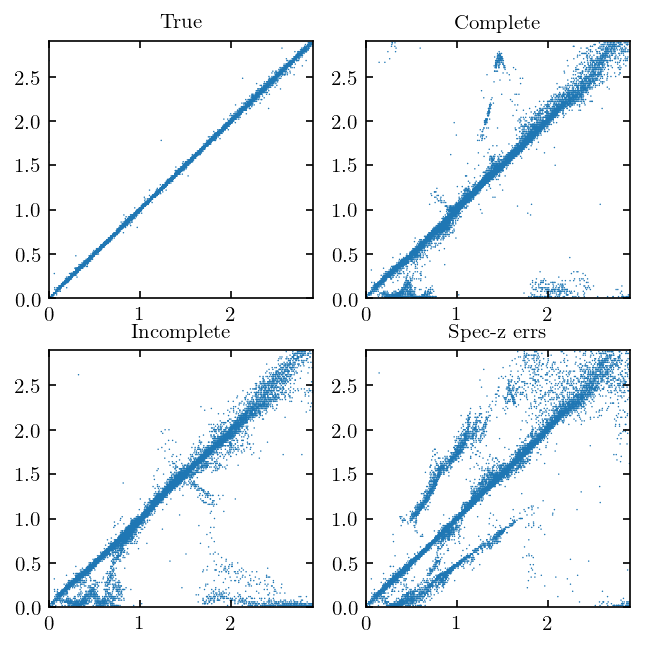

In [49]:
fig, axes = plt.subplots(2,2, figsize=(5,5))

for ax, title, pdfs in zip(axes.flatten(), 
                           ["True", "Complete", "Incomplete", "Spec-z errs"],
                           [true_pdfs, complete_pdfs, incomplete_pdfs, specz_err_pdfs]):
    
    idx = np.where(zmode(pdfs) < 2.9)
    ax.scatter(test_complete_sample["redshift"].values[idx], zmode(pdfs)[idx], s=0.5, edgecolor="None")
    ax.set(xlim=(0, 2.9), ylim=(0, 2.9), title=title)

There are a number of weird things going on here.
1. Why is the true photo-z vs spec-z so perfect? There should be larger degeneracies...
2. What are the low-specz -> even lower photo-z failures? I don't remember seeing that failure mode before.
3. What is that failure line above the spec=phot line in "Complete"?
4. The spec-z error lines in Spec-z errs are too intense. But I guess expected? I should make those more subtle...